In [1]:
# extract information from dump file.
import numpy as num
import matplotlib.pyplot as plt
import pylab as lab
from scipy import constants
import scipy as sci
import pandas as pan
import os
%matplotlib inline

In [49]:
def DumpExtractor(filename,frames,atomNumber,atomPlate):
    
    """
    infoDict=DumpExtractor(filename,frames,atomNumber,atomPlate)


    Function that extracts the information from the .dump file created by openmd
    
    
        Inputs:
      ===========
   
   
       filename:
   
               Path of the dump file from which the information is to be extracted
               
        frame:
    
                Total number of frames in the dump file
                
        atomNumber:
        
                Totla number of atoms in the slab or crystal
                
        atomPlate:
    
                Total number of atoms in the capacitor plates



        Outputs:
     =============
 
     infoDict:
 
         Dictonary containing position, velocity, chargeQV, electricField, plateEQV.
         Postion is a list of [x,y,z] and each x,y,z are array of x[frames][sites]
         velocity is a list of [vx,vy,vz] and each vx,vy,vz are array of vx[frames][sites]
         chargeQV is a lisf of [c,cv] and each c and cv are array of c[frame][sites]
         electric field is list of [ex,ey,ez] and each are array of ex[frame][sites]
         plateEQV is the list of [pex,pey,pez,pc,pcv] and each are array of pex[frames][sites]
    """
    
    fileDump=open(filename)  #dump file for info extraction
    linesDump=fileDump.readlines()

    processP="Wait"
    processC="Wait"


    #information storage matrix 
    #posiiton and velocity storage
    x=num.zeros((frames,atomNumber+1))
    y=num.zeros((frames,atomNumber+1))
    z=num.zeros((frames,atomNumber+1))
    vx=num.zeros((frames,atomNumber+1))
    vy=num.zeros((frames,atomNumber+1))
    vz=num.zeros((frames,atomNumber+1))


    #charge and velocity storage matrix
    c=num.zeros((frames,atomNumber+1))
    cv=num.zeros((frames,atomNumber+1))
    ex=num.zeros((frames,atomNumber+1))
    ey=num.zeros((frames,atomNumber+1))
    ez=num.zeros((frames,atomNumber+1))
    pc=num.zeros((frames,atomPlate))
    pcv=num.zeros((frames,atomPlate))
    pex=num.zeros((frames,atomPlate))
    pey=num.zeros((frames,atomPlate))
    pez=num.zeros((frames,atomPlate))

    #frame count initilization
    fCount=0
    index=0  #index for the atoms
    for line in linesDump:
        linesSplit=str.split(line)
        length=len(linesSplit)
    
        if(length!=0 and linesSplit[0]=="<StuntDoubles>" and processP=="Wait"):
            processP="Start"
            continue;
        
        elif(length!=0 and linesSplit[0]=="</StuntDoubles>" and processP=="Start"):
            processP="Wait"
            index=0
            continue;
        
        elif(length!=0 and linesSplit[0]=="<SiteData>" and processC=="Wait"):
            processC="Start"
            continue;
        
        elif(length!=0 and linesSplit[0]=="</SiteData>" and processC=="Start"):
            fCount=fCount+1
            index=0;
            processC="Wait"
            continue;
   
        elif(fCount>=frames):
            break;
        
        else:
            processP=processP;
            processC=processC;
        
        
        if (processP=="Start"):
            x[fCount][int(linesSplit[0])]=float(linesSplit[2])
            y[fCount][int(linesSplit[0])]=float(linesSplit[3])
            z[fCount][int(linesSplit[0])]=float(linesSplit[4])
            vx[fCount][int(linesSplit[0])]=float(linesSplit[5])
            vy[fCount][int(linesSplit[0])]=float(linesSplit[6])
            vz[fCount][int(linesSplit[0])]=float(linesSplit[7])
        
        if(processC=="Start"):
            if int(linesSplit[0])<atomNumber:
                c[fCount][int(linesSplit[0])]=float(linesSplit[3])
                cv[fCount][int(linesSplit[0])]=float(linesSplit[4])
                ex[fCount][int(linesSplit[0])]=float(linesSplit[5])
                ey[fCount][int(linesSplit[0])]=float(linesSplit[6])
                ez[fCount][int(linesSplit[0])]=float(linesSplit[7])
            elif (int(linesSplit[0])==atomNumber and linesSplit[1]=="cwe"):
                continue
                c[fCount][int(linesSplit[0])]=float(linesSplit[2])
                cv[fCount][int(linesSplit[0])]=float(linesSplit[3])
                ex[fCount][int(linesSplit[0])]=float(linesSplit[4])
                ey[fCount][int(linesSplit[0])]=float(linesSplit[5])
                ez[fCount][int(linesSplit[0])]=float(linesSplit[6])
            else:
                pc[fCount][int(linesSplit[1])]=float(linesSplit[3])
                pcv[fCount][int(linesSplit[1])]=float(linesSplit[4])
                pex[fCount][int(linesSplit[1])]=float(linesSplit[5])
                pey[fCount][int(linesSplit[1])]=float(linesSplit[6])
                pez[fCount][int(linesSplit[1])]=float(linesSplit[7])
        
    position=[x,y,z]
    velocity=[vx,vy,vz]
    chargeQV=[c,cv]
    electricField=[ex,ey,ez]
    platesEQV=[pex,pey,pez,pc,pcv]
    
    infoDict={"position":position,"velocity":velocity,"chargeQV":chargeQV,"electricField":electricField,"platesEQV":platesEQV}
    return infoDict

"""Function that determines different layers in a crystal

[layer,a]= Layers(ZPosition,atomNumber)
 
  Input:
 ========
 
         ZPosition: Z Coordinates of lattice for layer determination
         
         atomNumber: total Number of atoms in crystal
         
         
  Output:
 =========
         list [layer,a]; layer has index for atoms in each layers and "a" has the z-coordinates for each layers
         
         
"""
def Layers(ZPosition,atomNumber):
    a=num.sort(list(set(ZPosition[0,0:atomNumber-1])))
    layer=[]
    for var in a:
        layer.append(num.where(ZPosition[0]==var))
    
    return [layer,a]

def partialChargeDist(partialCharge,layersIndex,ZpositionOfLayers,outPath):
    crange=num.linspace(0,1,num.ceil(len(ZpositionOfLayers)**.33))
    colors=[(cr,cb,cg) for cr in crange for cb in crange for cg in crange]
    fig = lab.figure(1)
    ax = fig.add_subplot(111)
    for counter in range(len(ZpositionOfLayers)):
        lab.plot(num.sum(partialCharge[:,layersIndex[counter][0]],axis=1)\
                 /len(layersIndex[counter][0]),colors[counter],label=ZpositionOfLayers[counter])
    
    handles, labels = ax.get_legend_handles_labels()
    lab.xlabel("frames")
    lab.ylabel("average charge per site")
    lgd=ax.legend(bbox_to_anchor=(1.5,1),loc="upper right")
    if (outPath):
        lab.savefig(outPath,bbox_extra_artists=(lgd,), bbox_inches='tight')
    lab.show()
    


In [129]:
filename="/home/hbhattar/afs/Hemanta/metals/ChargeDiffLayers/Pt9/Slab_9_layers_Zhou_KMedium.dump"
frames=100
atomNumber=288
atomPlate=0
dump1=DumpExtractor(filename,frames,atomNumber,atomPlate)
layer,a=Layers(dump1["position"][2],atomNumber)

In [130]:
c=dump1["chargeQV"][0]

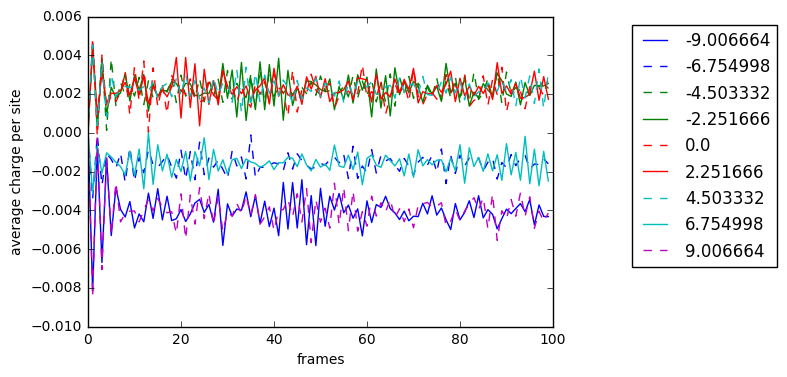

In [131]:
colors=['b','b--', 'g--','g','r--','r','c--','c','m--','m','y--','y'\
        , 'k--','k','b-.','g-.','r-.','c-.','m-.','y-.','k-.']
fig = plt.figure(1)
ax = fig.add_subplot(111)
chargeAve=[]
for counter in range(len(a)):
    chargeAve.append(num.sum(c[:,layer[counter][0]],axis=1)/len(layer[counter][0]))
    lab.plot(chargeAve[counter],colors[counter],label=a[counter])
    

handles, labels = ax.get_legend_handles_labels()
lab.xlabel("frames")
lab.ylabel("average charge per site")
lgd=lab.legend(bbox_to_anchor=(1.5,1),loc="upper right")
lab.show()

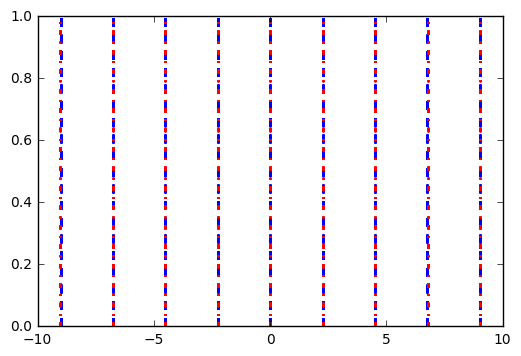

In [132]:
for var in dump1["position"][2][0][:-1]:
    lab.axvline(var,linestyle="--",color="blue")


for var in dump1["position"][2][99][:-1]:
    lab.axvline(var,linestyle="-.",color="red")


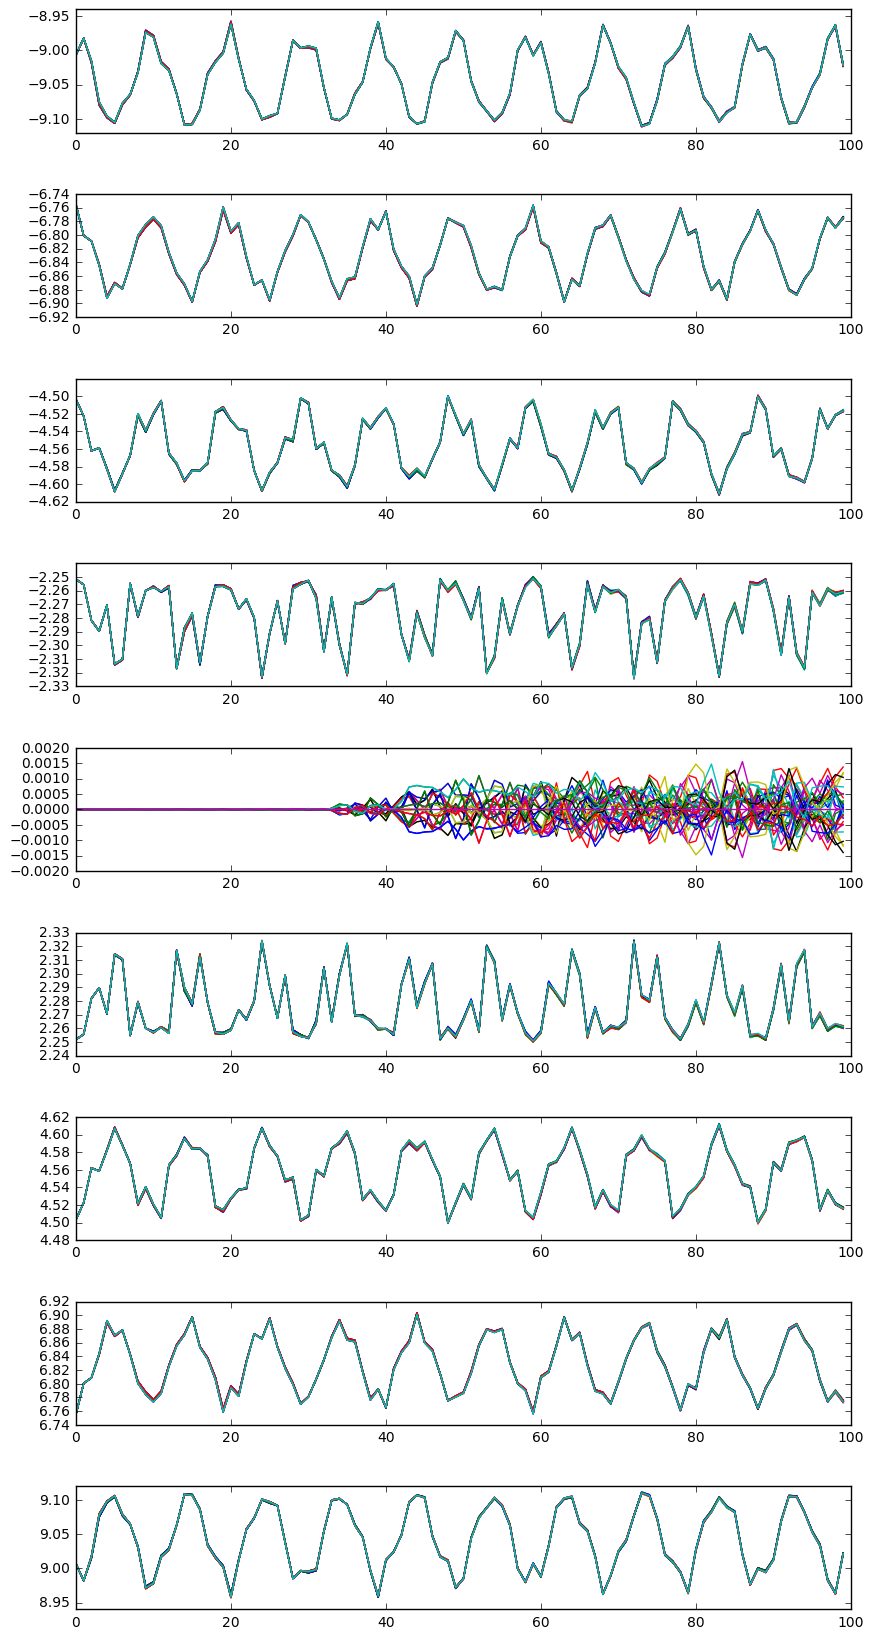

In [133]:
lab.figure(num=None, figsize=(10, 20), dpi=80, facecolor='w', edgecolor='k')
for counter in range(len(a)):
    lab.subplot(len(a),1,counter+1)
    lab.plot(dump1["position"][2][:,layer[counter][0]])
    



left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = .5   # the amount of height reserved for white space between subplots
lab.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

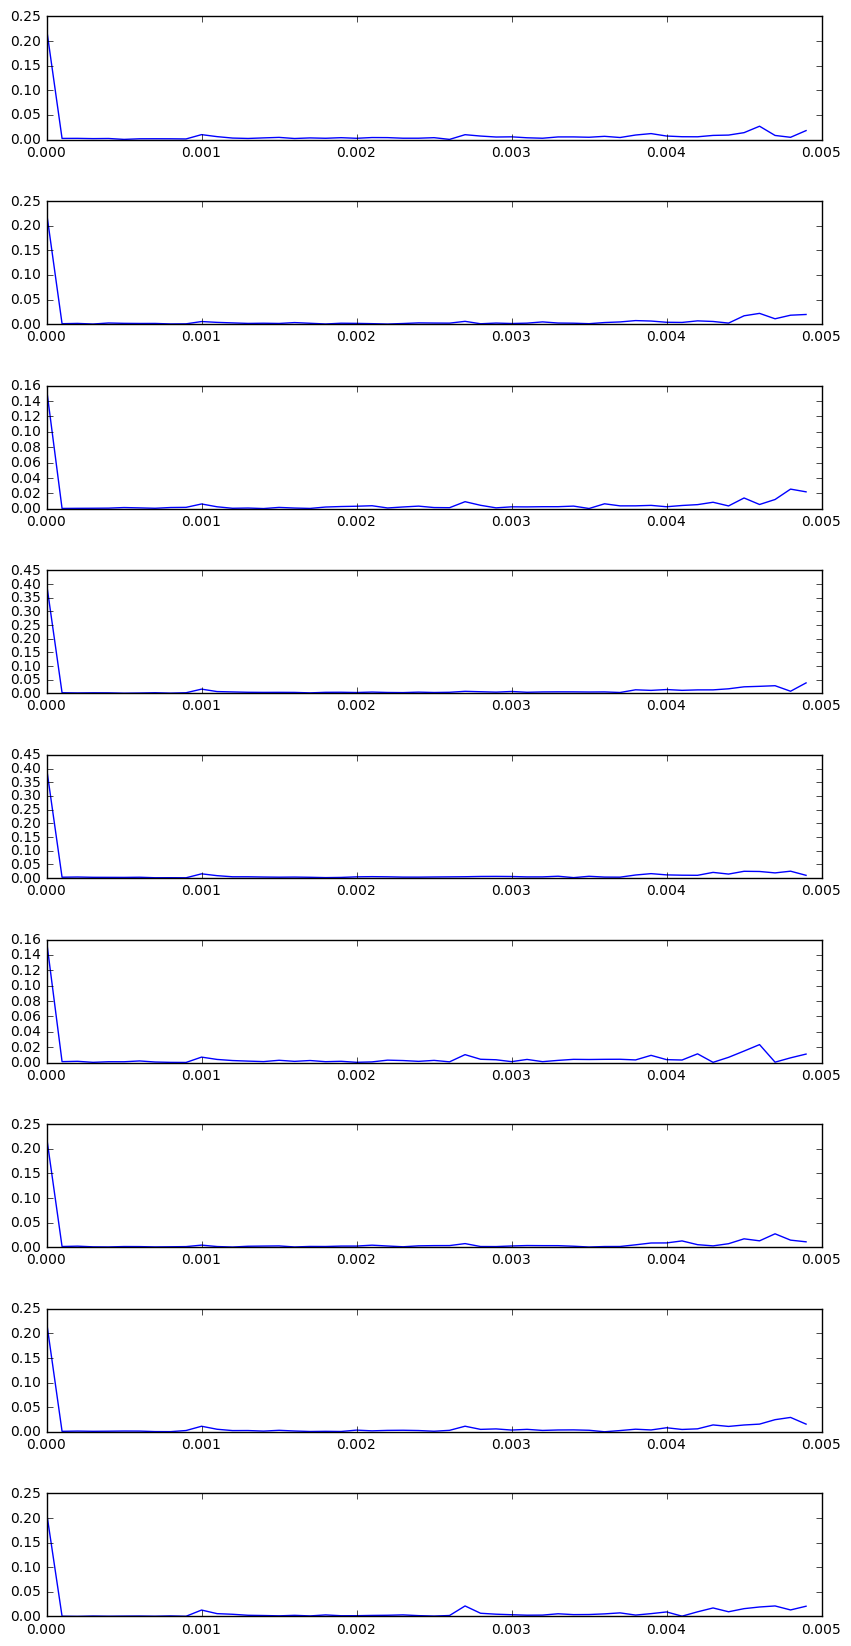

In [140]:
#fourier transform
from scipy.fftpack import fft,fftfreq,fftshift
N=100
T=100
cfour=fft(chargeAve)
freq=fftfreq(N,T)
freq=fftshift(freq)
yshift=fftshift(cfour)

lab.figure(num=None, figsize=(10, 20), dpi=80, facecolor='w', edgecolor='k')

for count in range(len(a)):
    lab.subplot(len(a),1,count+1)
    lab.plot(freq[int(N/2):int(N)], num.abs(yshift[count][int(N/2):int(N)]))
    
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = .5   # the amount of height reserved for white space between subplots
lab.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)   


(9, 100)